<h2> Clustering the Restaurants in Central Toronto </h2>

Import the necessary libraries:

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install geopy
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install folium
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are missing from the target environment:
  - nodejs==12
  - scikit-learn==0.21
  - tensorflow==1.13




/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are missing from the target environment:
  - nodejs==12
  - scikit-learn==0.21
  - tensorflow==1.13


Libraries imported.


<h3> Getting Data </h3>

Since this project would look into details about Toronto Area, we will use information available in the internet. Currently, Wikipedia offers the Available Neighborhoods in Toronto. To get these information, we would need to Data Wrangling methods as can be seen from below.

In [5]:
!pip install beautifulsoup4
from bs4 import BeautifulSoup

source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'html.parser')
table_contents=[]

table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Shape of the DataFrame obtained from Wikipedia. It can be inferred here that there are a total of 103 unique Postal codes obtained.

In [6]:
df.shape

(103, 3)

In order to plot in a Map, and better visualize, we would need the Latitude and Longitude values of each. This can be obtained from the shared link from coursera.

In [7]:
geo_data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv")

geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


To present the DataFrame which now includes the Latitude and Longitude

In [8]:
toronto_geo_data = pd.merge(df, geo_data, on='Postal Code')

toronto_geo_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [9]:
toronto_geo_data.shape

(103, 5)

We would try to plot the each Postal Code in the Map of Toronto. This will be done using Folium.

In [10]:
# create map of New York using latitude and longitude values
map_toronto= folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geo_data['Latitude'], toronto_geo_data['Longitude'], toronto_geo_data['Borough'], toronto_geo_data['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Since this project will only concentrate on <b>Central Toronto</b>, we will only get Borough values which are equal to this. It can be seen that there are a total of 9 Postal Codes in Central Toronto.

In [11]:
df_toronto_only = toronto_geo_data[toronto_geo_data['Borough'].str.contains("Central Toronto")].reset_index(drop=True)
df_toronto_only

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
5,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
6,M4S,Central Toronto,Davisville,43.704324,-79.388790
7,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
8,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049


To check the shape of the DataFrame wherein the Borough has the word "Central Toronto"

In [12]:
df_toronto_only.shape

(9, 5)

The map shown below shows the Postal codes wherein the Boroughs are only "<b> Central Toronto </b>"

In [13]:
# create map of New York using latitude and longitude values
map_toronto2= folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto_only['Latitude'], df_toronto_only['Longitude'], df_toronto_only['Borough'], df_toronto_only['Neighborhood']):
    label = '{}, {}'.format(borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

This project will utilize Foursquare! to determine the available restaurants in the Central Toronto Area

In [24]:
CLIENT_ID = 'CNFGEZ4TXAUWRNSIKPRELXTHXZWVCVFF2U5UEXFO5GJCWQAP' # your Foursquare ID
CLIENT_SECRET = 'BT3IIFOWX4UL2LVGT5LSB1R1ZTKDC31OVMNH0UGJJSU3QVNQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CNFGEZ4TXAUWRNSIKPRELXTHXZWVCVFF2U5UEXFO5GJCWQAP
CLIENT_SECRET:BT3IIFOWX4UL2LVGT5LSB1R1ZTKDC31OVMNH0UGJJSU3QVNQ


Getting the details of each Neighborhood in Central Toronto. Do note that the radius used here is 1000m. Thus, it should capture the available restaurants within 1000m of each Neighborhood

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
centraltoronoto_venues = getNearbyVenues(names=df_toronto_only['Neighborhood'],
                                   latitudes=df_toronto_only['Latitude'],
                                   longitudes=df_toronto_only['Longitude']
                                   )

Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
North Toronto West
The Annex, North Midtown, Yorkville
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park


In order to determine whether the available restaurants are captures, the code below will display the first 10 restaurants in Central Toronto

In [28]:
#centraltoronoto_venues.head()

restaurants_only_2 = centraltoronoto_venues[centraltoronoto_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
restaurants_only_2.head(10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roselawn,43.711695,-79.416936,7 Numbers,43.703630,-79.413724,Italian Restaurant
1,Roselawn,43.711695,-79.416936,Tokyo Sushi,43.704146,-79.410631,Sushi Restaurant
2,Roselawn,43.711695,-79.416936,Ferraro,43.703655,-79.413167,Italian Restaurant
3,Roselawn,43.711695,-79.416936,EDO,43.703754,-79.412802,Japanese Restaurant
4,Roselawn,43.711695,-79.416936,Kimono,43.704241,-79.410085,Sushi Restaurant
5,Roselawn,43.711695,-79.416936,Zen Sushi,43.703717,-79.414113,Sushi Restaurant
6,Davisville North,43.712751,-79.390197,Bar Buca,43.706961,-79.394808,Italian Restaurant
7,Davisville North,43.712751,-79.390197,La Vecchia Ristorante,43.710167,-79.399086,Italian Restaurant
8,Davisville North,43.712751,-79.390197,Kinton Ramen,43.707302,-79.395854,Ramen Restaurant
9,Davisville North,43.712751,-79.390197,Grazie Ristorante,43.709329,-79.398823,Italian Restaurant


In order to use the data in kNN clustering, it needs to be cleaned, and should have values for each type of restaurant or cuisine.

In [29]:
restaurant_CT_onehot = pd.get_dummies(restaurants_only_2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurant_CT_onehot['Neighborhood'] = restaurants_only_2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_CT_onehot.columns[-1]] + list(restaurant_CT_onehot.columns[:-1])
restaurant_CT_onehot = restaurant_CT_onehot[fixed_columns]

restaurant_CT_onehot.head()

restaurant_CT_onehot.insert(1,'Venue', restaurants_only_2['Venue'])
restaurant_CT_onehot.insert(2,'Venue Latitude', restaurants_only_2['Venue Latitude'])
restaurant_CT_onehot.insert(3,'Venue Longitude', restaurants_only_2['Venue Longitude'])

In [30]:

restaurant_CT_onehot.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,American Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Roselawn,7 Numbers,43.703630,-79.413724,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Roselawn,Tokyo Sushi,43.704146,-79.410631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Roselawn,Ferraro,43.703655,-79.413167,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Roselawn,EDO,43.703754,-79.412802,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Roselawn,Kimono,43.704241,-79.410085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


<h3> kNN Clustering </h3>

To use kMeans clustering for the nearby Venues in each Neigborhood. Note the the clusters used is the number of type of restaurants in the Central Toronto Area

In [31]:
kclusters = 26

restaurant_CT_onehot_cluster = restaurant_CT_onehot.drop('Neighborhood',1).drop('Venue',1).drop('Venue Latitude',1).drop('Venue Longitude',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_CT_onehot_cluster)


# check cluster labels generated for each row in the dataframe
kmeans.labels_

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/srv/conda/envs/notebook/lib/python3.7/site-

array([ 1,  2,  1,  3,  2,  2,  1,  1, 12,  1,  1,  6,  7,  2,  4,  4,  3,
       20,  2,  8,  2,  9,  1,  8,  4, 14, 15, 12,  5,  4,  9,  9,  1,  2,
        1, 11,  3,  3, 25,  9,  4,  6,  2,  4,  1,  1,  1,  8, 14,  7,  4,
        2,  5,  8, 12, 10, 11,  8,  6,  1,  1,  0, 22,  5, 15,  6, 24,  1,
       18,  4,  0, 13,  1,  3,  8,  1,  6, 11,  4,  4,  5,  6, 17, 10, 20,
        1,  2,  1,  1,  1, 12,  4,  6,  5,  0, 11,  1,  2,  4,  1,  7,  3,
        2,  9,  1, 23,  2,  8, 15, 21,  2,  2,  8, 11,  4, 10,  4, 10,  1,
        2,  1, 11,  1,  4,  1,  5, 17,  2,  1, 19, 16,  4,  3,  1, 13,  7,
        2,  5,  5, 18,  1,  2,  4,  2, 17,  6,  1,  2,  1, 19, 16,  4,  1,
        2, 13,  5,  3,  7,  5,  2,  5,  5, 14], dtype=int32)

Fixing the dataframe to plot

In [32]:
restaurant_CT_onehot_cluster.head()
restaurant_CT_onehot_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
restaurant_CT_onehot_cluster.insert(1,'Neighborhood', restaurant_CT_onehot['Neighborhood'])
restaurant_CT_onehot_cluster.insert(2,'Venue', restaurant_CT_onehot['Venue'])
restaurant_CT_onehot_cluster.insert(3,'Venue Latitude', restaurant_CT_onehot['Venue Latitude'])
restaurant_CT_onehot_cluster.insert(3,'Venue Longitude', restaurant_CT_onehot['Venue Longitude'])

Plotting the available restaurants in Central Toronto according to the result of kNN Clustering. Note that same restaurant type should have the same Clusters. Thus, all Chinese Restaurants should be in the same cluster.

In [33]:
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurant_CT_onehot_cluster['Venue Latitude'], restaurant_CT_onehot_cluster['Venue Longitude'], restaurant_CT_onehot_cluster['Venue'], restaurant_CT_onehot_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3> Analysis </h3>

Determining the count of each cluster.

In [34]:
bar_graph = restaurant_CT_onehot_cluster['Cluster Labels'].value_counts()
bar_graph.rename_axis('Cluster Labels').reset_index(name='Count')

,Cluster Labels,Count
0,1,34
1,2,23
2,4,18
3,5,12
4,3,8
5,6,8
6,8,8
7,11,6
8,7,5
9,9,5


To better visualize, we can plot this in a bar graph.

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt


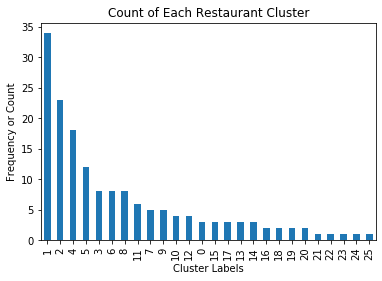

In [36]:
bar_graph.plot(kind ='bar')

plt.title("Count of Each Restaurant Cluster")
plt.xlabel("Cluster Labels")
plt.ylabel("Frequency or Count")

plt.show()

It can be concluded from the code below that cluster 1 is equal to Italian Restaurants. Thus, we can say that Italian Restaurant is the prominent in Central Toronto.

In [37]:
s1 =restaurant_CT_onehot_cluster.loc[restaurant_CT_onehot_cluster['Cluster Labels'] == 1, restaurant_CT_onehot_cluster.columns[[1] + list(range(5, restaurant_CT_onehot_cluster.shape[1]))]]

In [38]:
s1.head()

,Neighborhood,American Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Roselawn,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Roselawn,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Davisville North,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Davisville North,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Davisville North,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, in the next few line, we will determine which of the Neighborhoods has the most number of Italian Restaurants.

In [39]:
a1 = s1['Neighborhood'].value_counts()

a1.rename_axis('Neighborhood').reset_index(name='Count')

,Neighborhood,Count
0,Davisville,9
1,"The Annex, North Midtown, Yorkville",5
2,Davisville North,5
3,"Moore Park, Summerhill East",4
4,"Summerhill West, Rathnelly, South Hill, Forest...",4
5,North Toronto West,3
6,Forest Hill North & West,2
7,Roselawn,2


It can be concluded that Davisville has the most number of Italian Restaurants. Thus, if someone will set-up a restaurant that people of Central Toronto are familiar with, they can choose Italian. Based from the quantities, it can be put up in Roselawn or Forest Hill North & West. 

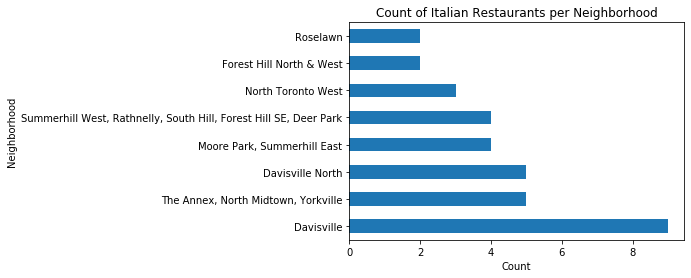

In [40]:
a1.plot(kind ='barh')

plt.title("Count of Italian Restaurants per Neighborhood")
plt.xlabel("Count")
plt.ylabel("Neighborhood")

plt.show()

Now, we will determine which restaurant type came in second:

In [45]:
s2 =restaurant_CT_onehot_cluster.loc[restaurant_CT_onehot_cluster['Cluster Labels'] == 2, restaurant_CT_onehot_cluster.columns[[1] + list(range(5, restaurant_CT_onehot_cluster.shape[1]))]]

In [46]:
s2.head()

,Neighborhood,American Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Roselawn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Roselawn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,Roselawn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13,Davisville North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
18,Davisville North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [47]:
a2 = s2['Neighborhood'].value_counts()

a2.rename_axis('Neighborhood').reset_index(name='Count')

,Neighborhood,Count
0,Davisville,7
1,"Summerhill West, Rathnelly, South Hill, Forest...",5
2,Roselawn,3
3,Davisville North,3
4,Forest Hill North & West,2
5,"Moore Park, Summerhill East",2
6,North Toronto West,1


It can be concluded from the bar graph below, that people from Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park has the most choices of sushi restaurants.

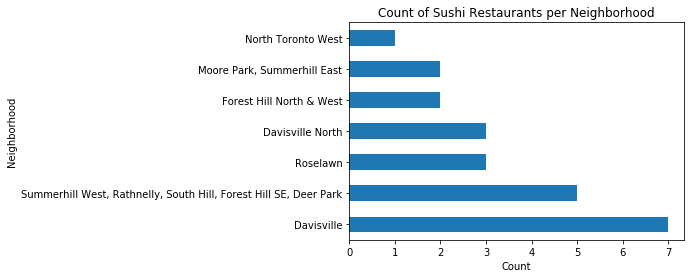

In [48]:
a2.plot(kind ='barh')

plt.title("Count of Sushi Restaurants per Neighborhood")
plt.xlabel("Count")
plt.ylabel("Neighborhood")

plt.show()